# 09 Shape Regularisation Methods 
based on:
https://d2l.ai/chapter_computer-vision/rcnn.html

In [1]:
import sys
import os
import random
import numpy as np
import datetime
import shutil
import logging

import torch
import torch.nn as nn
from torch import autograd
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.utils as vutils
import torch.optim as optim

import matplotlib.pyplot as plt

sys.path.append("../src/models/")
sys.path.append("../src/utils/")
from Generator import OptGen, OptGenGreyscale
from Discriminator import OptDis
from utils import normalizeRGB
from utils import weights_init
from OptimisationFunctions import suggest_hyperparameters, trainModel, test, objective, gradient_penalty

%matplotlib inline

%load_ext autoreload
%autoreload 2

# 1. Set the Parameters

In [2]:
dataroot = "../../png/train" # Root directory for train dataset
datarootTest = "../../png/test" # Root directory for dataset
cadastralRoot = '../../cadastralExportRGB' # Root directory for cadastral images
cadastralRootGreyscale = '../../cadastralExport' # Root directory for cadastral images in greyscale
workers = 2 # Number of workers for dataloader
batch_size = 64 # Batch size during training
image_size = 64 # Spatial size of training images. All images will be resized to this
nc = 3 # Number of channels in the training images. For color images this is 3
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 500 # Number of training epochs
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
lambda_gradient_penality = 0.2 # to adjust the Wasserstein distance with interpolation between real and fake data
ngpu = torch.cuda.device_count() # Number of GPUs available. Use 0 for CPU mode.

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter("%(asctime)s:%(levelname)s:%(message)s")
file_handler = logging.FileHandler('../reports/09_Regularization.log')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# 2. Load Dataset

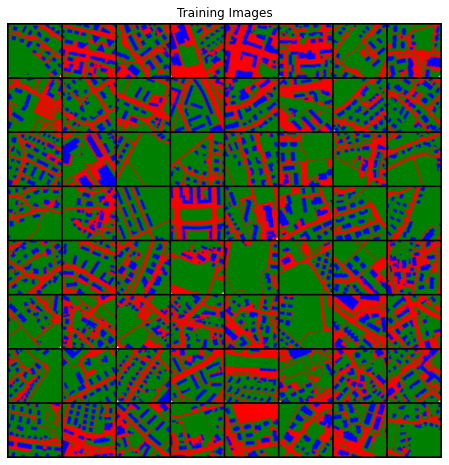

In [3]:
# We can use an image folder dataset the way we have it setup
if os.path.exists(cadastralRoot + '/.ipynb_checkpoints'):
    shutil.rmtree(cadastralRoot + '/.ipynb_checkpoints')

Cad_dataset = dset.ImageFolder(root=cadastralRoot,
                           transform=transforms.Compose([
                               transforms.RandomRotation(degrees=(0,180), expand = False),
                               transforms.CenterCrop(image_size * 11),
                               transforms.Resize(image_size),
                               # transforms.RandomCrop(image_size),
                               transforms.ToTensor(),
                               # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), -> 
                           ]))
# Create the dataloader
Cad_dataloader = torch.utils.data.DataLoader(Cad_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
Cad_real_batch = next(iter(Cad_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(Cad_real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

## 2.1 Create a Mask for the buildings

In [39]:
i = random.sample(range(batch_size), 1)[0]

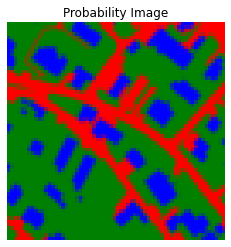

In [40]:
plt.title('Probability Image')
plt.axis('off')
plt.imshow(Cad_real_batch[0][i].permute(1,2,0));

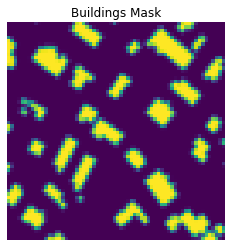

In [41]:
plt.title('Buildings Mask')
plt.axis('off')
plt.imshow(Cad_real_batch[0][i][2]);

In [29]:
def to_mask_value(x: float, threshold: float = 0.5):
    '''
    regularize the value of the input to 0 or 1 to create a mask
    '''
    if x <= threshold:
        x = 0
    elif x >= threshold:
        x = 1
    return x

def postprocess_to_mask(img: torch.Tensor, threshold: float = 0.75):
    '''
    postprocesses an image to return a mask
    '''
    dims = img.size()
    img = img.flatten()
    img.apply_(to_mask_value)
    img = img.view(dims)
    return img

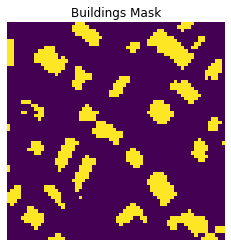

In [42]:
plt.title('Buildings Mask')
plt.axis('off')
plt.imshow(postprocess_to_mask(Cad_real_batch[0][i])[2]);

In [24]:
postprocess_to_mask(Cad_real_batch[0][i])[2]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

# 3. Some thoughts on shape regularization
The model based on probability of a pixel to belong to a certain class is using the masks, since each level can be interpreted as a the mask for a specific class.
This approach is in effect already implemented by the normal generator, that tries to learn how to realize realistic masks. 
Another approach could be giving a series of building bounding boxes to condition the generator. The same building bounding boxes can be derived by realimages and provided to the discriminator as additional information to classify real and fake images. 

#### 3.1 Notes on the implementation
This approach is possible with CGANs.
1. let's say there are N or less buildings in the area
2. for each building there is a tensor with 2 coordinates for the starting point of the bounding box, two coordinates for the end point of the bounding box, the number of pixels classified as building. With this approach it is also possible to create buildings rotated within the bounding box (less than 100% pixels classified as building) or with irregular shapes. The algorighm should not only classify each pixel in the box as building. If there are less than N buildings, the tensor is filled with 0s.
3. The information is fed in the discriminator through embeddings (as condition, similar to the percentage of roads, green and buildings).
4. The generator receives also random generated (not so random, a function with stochastic elements need to be defined) hints as conditions.